# Simple expansion-repression circuit 

In [2]:
# Import Python libraries
import numpy as np 
import matplotlib.pyplot as plt 


Notebook initialised


In [3]:
# Set global plotting parameters
plt.rcParams['figure.figsize'] = [10, 6]   # Controls default figure size (in inches)
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('font', size = SMALL_SIZE)          # Controls default text sizes
plt.rc('axes', titlesize = SMALL_SIZE)     # Fontsize of the axes title
plt.rc('axes', labelsize = MEDIUM_SIZE)    # Fontsize of the x and y labels
plt.rc('xtick', labelsize = SMALL_SIZE)    # Fontsize of the tick labels
plt.rc('ytick', labelsize = SMALL_SIZE)    # Fontsize of the tick labels
plt.rc('legend', fontsize = SMALL_SIZE)    # Legend fontsize
plt.rc('figure', titlesize = BIGGER_SIZE)  # Fontsize of the figure title

In [4]:
# Define function to plot results
def plot(fig, ax, x, y, L, xLabel = None, yLabel = None, colour='black', figwidth = 10, figlength = 6, linewidth = 4, linestyle='-', linelabel = None):
    fig.set_size_inches(figwidth, figlength, forward = True)
    ax.plot(x, y, linewidth = linewidth, color = colour, linestyle = linestyle,label=linelabel)
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.set_xlim([0, L])
    ax.set_ylim([0,None])
    if linelabel != None:
        ax.legend()
    return fig, ax

In [5]:
# Define system parameters
d = 10            # Diffusion coefficient
k = 10**(-1)           # Degradation rate
c0 = 10          # Pinned concentration at x = 0
L = 100            # Tissue size

# Define simulation parameters
Nx = 201           # Number of spatial (x) gridpoints
tMax = 10000000      # Maximum time
thresholdSS = 1e-8 # Maximum fractional change in concentration per unit time below which the code exits as it has reached steady state

In [6]:
# Define a function to extract the position corresponding to a concentration threshold (inverse of above)
def findXThresh(cThresh, x, conc):
    """ Extracts the position corresponding to a concentration threshold.
    Inputs:
    cThresh - The threshold concentration
    x -  The position (x-axis) array
    conc - The concentration (y-axis) array
    """
    # Find indexes corresponding to concentrations below cThresh
    cInd = [i for i, val in enumerate(conc) if val < cThresh]

    # Check if any indexes were found
    if(len(cInd) > 0):

        # Extract index corresponding to concentration just below cThresh
        cInd = cInd[0]

        # Use linear interpolation to find concentration at position
        m = (conc[cInd] - conc[cInd - 1]) / (x[cInd] - x[cInd - 1]) # The gradient of the morphogen profile between the two points
        return x[cInd] + ((cThresh - conc[cInd]) / m)

    else:
        print("No concentrations are below the threshold")
        return None

Next we solve the expansion-repression circuit using a simplified model where $\beta$=0, meaning the morphogen cocnentration doesn't repress the expander production. The equations of motion for the morphogen and expander are described by $[M[x,t+h] = D_Md(M[x+h,t]-2M[x,t] + M[x-h,t]) + (1-\alpha)kM[x,t]$ and $[ E[x,t+h] = D_Ed(E[x+h,t]-2E[x,t] + E[x-h,t]) + (1-\alpha)kE[x,t] + \beta_E h(M)$, respectively.


In [7]:
def Solve_E(d, k, c0, L, Nx, tMax, thresholdSS,const):
    """ Solves a simplifed version of the expansion-repression circuit.
    Inputs:
    d - Diffusion coefficient for the morphogen 
    k - Degradation rate for the morphogen 
    C0 - Pinned concentration at x = 0
    L - Tissue size
    Nx- Number of spatial (x) gridpoints
    tMax - Maximum time
    thresholdSS - Maximum fractional change in concentration per unit time below which the code exits as it has reached steady state (SS)
    const - concentration of the expander 
    Outputs:
    concCurr - concentration of the morphogen at the maximum time or at steady state 
    concCurr_E - concentration of the expander at the maximum time or at steady state
    """

    # Parameters for the expander
    alpha_E = 10**(-5)  # degradation of expander
    D_E = 1  # diffusivity of the expander
    cE_base = const  # concentration of the expander
    B = 0 #beta, the repression of the expander by the morphogen 

    # Calculate spatial variables
    dx = L / (Nx - 1)  # Spatial grid spacing

    # Define temporal variables
    dt = 1 / (k + ((4 * d) / (dx ** 2)))  # Time step, from the von Neumann stability condition
    Nt = round((tMax / dt) + 1)  # The maximum number of time points
    tCount = 0  # The current timestep

    # Non-dimensionalize variables
    d *= dt / (dx ** 2)
    k *= dt

    # Initialize buffer array to store the concentrations at the previous timestep
    concPrev = np.zeros(Nx)
    concPrev[0] = c0

    # Initialize buffer array for expander concentration
    concPrev_E = np.zeros(Nx)

    # Define flag to indicate when the system has reached steady state (SS)
    flagSS = False

    # Loop over time until the maximum number of time points or until the system reaches steady state (SS)
    while not flagSS and tCount < Nt:
        # Update the timestep counter
        tCount += 1
        
        # Update expander concentration
        concCurr_E = np.zeros(Nx)
        #concCurr_E[0]=((1 - (alpha_E * k)) * concPrev[0]) + (2 * (d * D_E)* (concPrev[1] - concPrev[0]))
        #concCurr_E[0] = ((1 - (alpha_E * k)) * concPrev_E[Nx - 1]) + (2 * d * D_E * (concPrev_E[Nx - 2] - concPrev_E[Nx - 1]))
        concCurr_E[Nx - 10:Nx] = cE_base
        #concCurr_E[Nx - 10:Nx] = ((1 - (alpha_E * k)) * concPrev[Nx]) + (2 * (d * D_E)* (concPrev[Nx - 1] - concPrev[Nx]))
        #concCurr_E[Nx - 10:Nx] = ((1 - (alpha_E * k)) * concPrev[Nx - 1]) + (2 * (d * D_E)* (concPrev[Nx - 2] - concPrev[Nx - 1]))
        #concCurr_E[N−9:N+1]=((1−(alpha E×k))×concPrev[N])+(2×(d×D E)×(concPrev[N−1]−concPrev[N]))
        concCurr_E[1:Nx - 10] = ((1 - (alpha_E * k)) * concPrev_E[1:Nx - 10]) + ((d * D_E) * (concPrev_E[2:Nx-9] + concPrev_E[0:Nx - 11] - (2 * concPrev_E[1:Nx - 10])))+B
        concCurr_E[0] = concCurr_E[1]
        concPrev_E = np.array(concCurr_E)
        
        alpha_M = 1 / (1 + concPrev_E)

        # Update the concentration
        concCurr = np.zeros(Nx)
        #print(np.shape(alpha_M))
        #print(np.shape(k))
        concCurr[0] = c0
        concCurr[1:Nx - 1] = ((1 - (alpha_M[1:Nx-1] * k)) * concPrev[1:Nx - 1]) + (d * (concPrev[2:Nx] + concPrev[0:Nx - 2] - (2 * concPrev[1:Nx - 1])))
        concCurr[Nx - 1] = ((1 - (alpha_M[Nx-1] * k)) * concPrev[Nx - 1]) + (2 * d * (concPrev[Nx - 2] - concPrev[Nx - 1]))

        # Check steady state condition
        delC = np.sum(np.abs(concCurr - concPrev)) / (np.sum(concCurr) * dt)
        if delC < thresholdSS:
            flagSS = True
            print("Steady state reached at t =", tCount * dt, "s")

        # Re-initialize the previous concentration vector ready for the next loop
        concPrev = np.array(concCurr)

    # Output the final concentration
    return concCurr, concCurr_E 

Steady state reached at t = 141.91755153029357 s
Steady state reached at t = 4153.660212367271 s
Steady state reached at t = 4252.548407245472 s
Steady state reached at t = 4289.643972517177 s
Steady state reached at t = 4308.026233603998 s
Steady state reached at t = 4318.525921299189 s
Steady state reached at t = 4325.096814490944 s
Steady state reached at t = 4329.52529668957 s
Steady state reached at t = 4332.69206745784 s
Steady state reached at t = 4335.078076202374 s
Steady state reached at t = 4336.970643347908 s


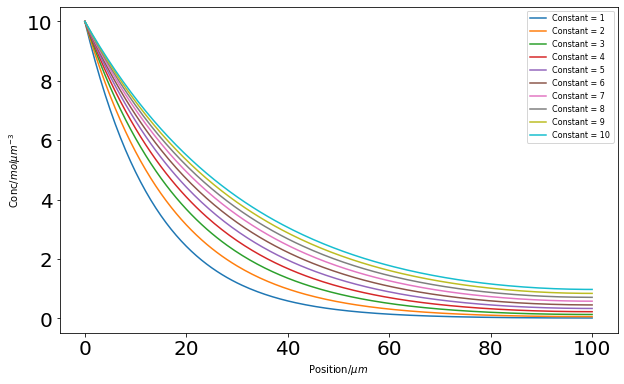

In [8]:

# Initialise arrays to store results
all_conc_M = []
all_conc_E = []
#variations in the initial cocnentration of the expander 
constant = [1,2,3,4,5,6,7,8,9,10]

x = np.linspace(0, L, Nx)
conc_original,conc_l = Solve_E(d, k, c0, L, Nx, tMax, thresholdSS, 0) #basic system for comparison
position_original = findXThresh(5, x, conc_original) #position of the threshold in the basic system 

percentages = [] #percentage change in the threshold position 
for i in constant:
    # Calculate decay length
    lam = np.sqrt(d / k)

    # Define x-axis for plotting
    x = np.linspace(0, L, Nx)

    # Calculate the steady state concentration
    conc_M, conc_E = Solve_E(d, k, c0, L, Nx, tMax, thresholdSS, i)
    
    position_new = findXThresh(5, x, conc_M) #new threshold position 
    
    #percentage change in the threshold position 
    percent = ((position_new-position_original)/position_original)*100
    percentages.append(percent)

    # Append results to arrays
    all_conc_M.append(conc_M)
    all_conc_E.append(conc_E)

# Plot results
fig, ax = plt.subplots() # Initiate the figure and axes

for i, (conc_M, conc_E) in enumerate(zip(all_conc_M, all_conc_E)):
    label = f'Constant = {constant[i]}' # Generate label for the plot
    ax.plot(x, conc_M, label=label) # Plot morphogen concentration
    #ax.plot(x, conc_E, label=label, color='pink') # Plot expander concentration

# Set labels and legend
ax.set_xlabel('Position/$\mu m$', fontsize=12)
ax.set_ylabel('Conc/$mol \mu m^{-3}$', fontsize=12)
ax.legend(fontsize=10) 

plt.show()


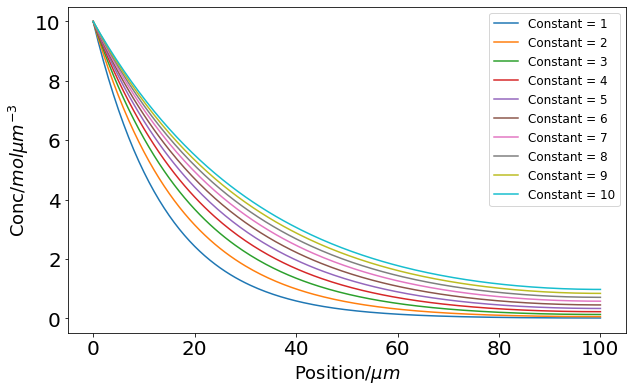

In [12]:
# Plot results
fig, ax = plt.subplots() # Initiate the figure and axes

for i, (conc_M, conc_E) in enumerate(zip(all_conc_M, all_conc_E)):
    label = f'Constant = {constant[i]}' # Generate label for the plot
    ax.plot(x, conc_M, label=label) # Plot morphogen concentration
    #ax.plot(x, conc_E, label=label, color='pink') # Plot expander concentration

# Set labels and legend
ax.set_xlabel('Position/$\mu m$', fontsize=18)
ax.set_ylabel('Conc/$mol \mu m^{-3}$', fontsize=18)
ax.legend(fontsize=12) 

plt.show()


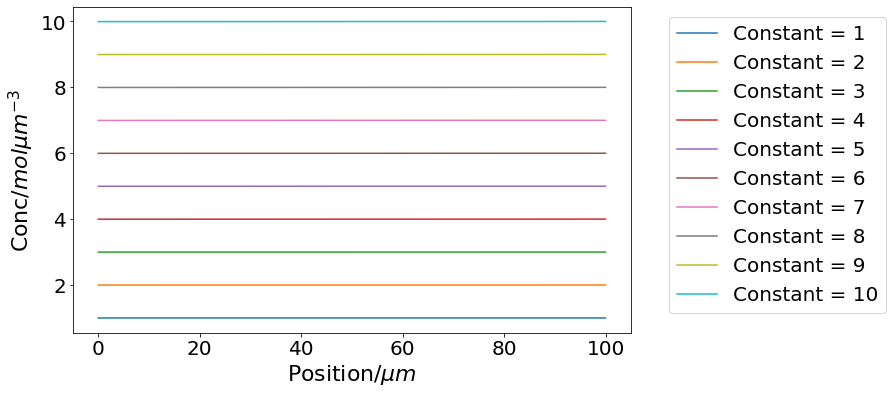

In [9]:
# Plot results
fig, ax = plt.subplots() # Initiate the figure and axes
for i, (conc_M, conc_E) in enumerate(zip(all_conc_M, all_conc_E)):
    label = f'Constant = {constant[i]}' # Generate label for the plot
    #ax.plot(x, conc_M, label=label) # Plot morphogen concentration
    ax.plot(x, conc_E, label=label) # Plot expander concentration

# Set labels and legend
ax.set_xlabel('Position/$\mu m$')
ax.set_ylabel('Conc/$mol \mu m^{-3}$')
ax.legend()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.show()